In [3]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.6 MB/s eta 0:00:00


##

https://medium.datadriveninvestor.com/how-to-detect-support-resistance-levels-and-breakout-using-python-f8b5dac42f21

In [13]:

from mplfinance.original_flavor import candlestick_ohlc
import yfinance as yf
import numpy as np
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import pandas as pd


In [16]:
def get_stock_price(symbol):
  df = yf.download(symbol, start='2022-06-01', threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df

In [17]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0

In [18]:
#method 1: fractal candlestick pattern
def detect_level_method_1(df):
  levels = []
  for i in range(2,df.shape[0]-2):
    if is_support(df,i):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
    elif is_resistance(df,i):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
  return levels

#method 2: window shifting method
def detect_level_method_2(df):
  levels = []
  max_list = []
  min_list = []
  for i in range(5, len(df)-5):
      high_range = df['High'][i-5:i+4]
      current_max = high_range.max()
      if current_max not in max_list:
          max_list = []
      max_list.append(current_max)
      if len(max_list) == 5 and is_far_from_level(current_max, levels, df):
          levels.append((high_range.idxmax(), current_max))
      
      low_range = df['Low'][i-5:i+5]
      current_min = low_range.min()
      if current_min not in min_list:
          min_list = []
      min_list.append(current_min)
      if len(min_list) == 5 and is_far_from_level(current_min, levels, df):
          levels.append((low_range.idxmin(), current_min))
  return levels

# to detect breakout
def has_breakout(levels, previous, last):
  for _, level in levels:
    cond1 = (previous['Open'] < level) 
    cond2 = (last['Open'] > level) and (last['Low'] > level)
  return (cond1 and cond2)

# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))   
  candlestick_ohlc(ax,df.values,width=0.6, colorup='green', 
    colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = 
      max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_32620/920621673.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


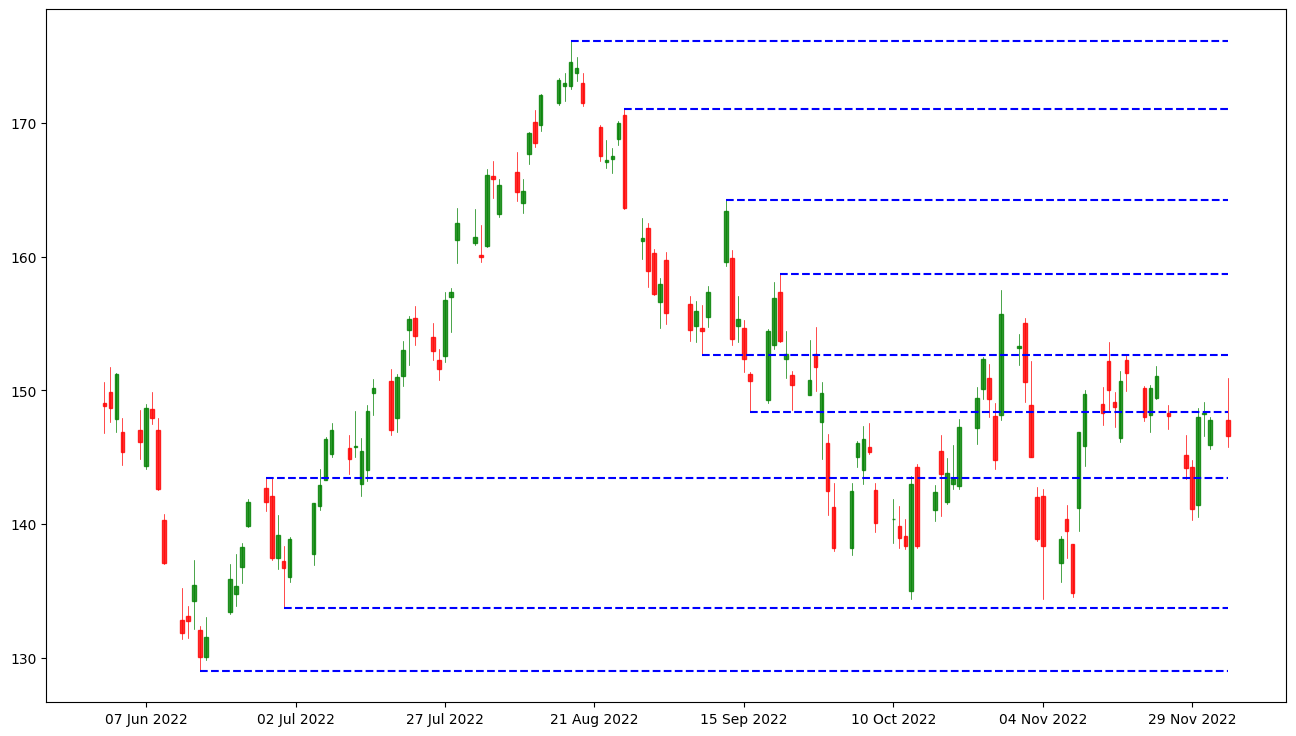

In [19]:
df = get_stock_price('AAPL')

pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
  # taking a window of 9 candles
  high_range = df['High'][i-5:i+4]
  current_max = high_range.max()
  # if we find a new maximum value, empty the max_list 
  if current_max not in max_list:
    max_list = []
  max_list.append(current_max)
  # if the maximum value remains the same after shifting 5 times
  if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
      pivots.append((high_range.idxmax(), current_max))
    
  low_range = df['Low'][i-5:i+5]
  current_min = low_range.min()
  if current_min not in min_list:
    min_list = []
  min_list.append(current_min)
  if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
    pivots.append((low_range.idxmin(), current_min))
plot_all(pivots, df)

In [20]:
# get levels using the first method
levels_1 = detect_level_method_1(df)
if (has_breakout(levels_1[-5:], df.iloc[-2], df.iloc[-1])):
    print("has fucking breakout method 1")

# get levels using the second method
levels_2 = detect_level_method_2(df)
if (has_breakout(levels_2[-5:], df.iloc[-2], df.iloc[-1])):
    print("has fucking breakout method 2")